### Visualize the MRI images and the segmentation results of the tumors.
- MRI images: t1, t1Gd, t2，flair.
- Tumor segmentations: 
                {"necrotic (NCR)": 1, 
                "peritumoral edematous/invaded tissue (ED)": 2,
                "enhancing tumor(ET)": 4,
                "tumor core (TC)": [1,4],
                "wholeTumor": [1, 2, 4]}

In [7]:
import os
import numpy as np
import sys
import gc
import matplotlib.pyplot as plt

import nibabel as nib



In [8]:
#sys.path.append("../")
#from utils.myUtils import traversalDir_FirstDir, mkdir

# Function: get the list of the first sub-folders in a given dir
from glob import glob
import os.path
def traversalDir_FirstDir(path):
    FirstDir_list = []
    if (os.path.exists(path)):
        files = glob(path + '\\*' )

        for file in files:
            if (os.path.isdir(file)):
                FirstDir_list.append(os.path.split(file)[1])
                
    return FirstDir_list


# Function: make a directory.
def mkdir(path):
    import os
    isExist=os.path.exists(path)
    if not isExist:
        os.makedirs(path) 
        print(path," is created successfully!")
#     else:
#         print(path, "exists already!")  

In [9]:
#from mySettings import get_image_visualization_setting_dict


import os

#============================   Used for main_visualize_images_and_tumors.ipynb =================================
def get_image_visualization_setting_dict():
    # base path
    base_dataPath="G:\Dataset\Xiangya_data"
    
    # base settings
    modality_list=["t1", "T1Gd", "t2", "flair"]
        
       
    #define settings for visualizing images.
    image_visualization_setting_dict={}
    image_visualization_setting_dict["XiangYa"]={
        "image_folder": base_dataPath+"/captk_before_data_zscore_normalizedImages",
        "segmentation_folder": base_dataPath+"/captk_before_data_net_seg",
        "modality_list":modality_list,
        "save_visualization_folder":base_dataPath+"/check_data_seg_50_VisualizeMaxSlice",
    }
        
    return image_visualization_setting_dict

In [10]:
"""
Show label on images.

References: 
https://github.com/naomifridman/Unet_Brain_tumor_segmentation/blob/master/Brats_segmentation_preprocess_data.ipynb
https://github.com/naomifridman/Unet_Brain_tumor_segmentation/blob/master/visualization_utils.py
"""
#--------------------------------------------------------------
from skimage import io, color, img_as_float
from skimage.exposure import adjust_gamma

# Creates an image of original brain with segmentation overlay
def show_lable_on_image(test_img, test_lbl):

        modes = {'flair':0, 't1':1, 't1c':2, 't2':3}

        label_im = test_lbl
        
        ones = np.argwhere(label_im == 1)
        twos = np.argwhere(label_im == 2)
        threes = np.argwhere(label_im == 3)
        fours = np.argwhere(label_im == 4)

        gray_img = img_as_float(test_img/test_img.max())

        # adjust gamma of image
        image = adjust_gamma(color.gray2rgb(gray_img), 0.45)
        #sliced_image = image.copy()

        red_multiplier = [1, 0.2, 0.2]
        green_multiplier = [0.35,0.75,0.25]
        blue_multiplier = [0,0.5,1.]#[0,0.25,0.9]
        yellow_multiplier = [1,1,0.25]
        brown_miltiplier = [40./255, 26./255, 13./255]

        # change colors of segmented classes
        for i in range(len(ones)):
            image[ones[i][0]][ones[i][1]] = red_multiplier#red_multiplier
        for i in range(len(twos)):
            image[twos[i][0]][twos[i][1]] = green_multiplier
        for i in range(len(fours)):
            image[fours[i][0]][fours[i][1]] = yellow_multiplier #yellow_multiplier

        return image
    
#-------------------------------------------------------------------------------------
def show_lable_on_image4(test_img, label_im):
        
    alpha = 0.8

    img = img_as_float(test_img/test_img.max())
    rows, cols = img.shape

    # Construct a colour image to superimpose
    color_mask = np.zeros((rows, cols, 3))
    red_multiplier = [1, 0.2, 0.2]
    green_multiplier = [0.35,0.75,0.25]
    blue_multiplier = [0,0.25,0.9]
    yellow_multiplier = [1,1,0.25]
    brown_miltiplier = [40./255, 26./255, 13./255]
    
        
    color_mask[label_im==1] = red_multiplier#[1, 0, 0]  # Red block
    color_mask[label_im==2] = green_multiplier#[0, 1, 0] # Green block
    color_mask[label_im==4] = yellow_multiplier#[0, 1, 1] # Blue block

    # Construct RGB version of grey-level image
    img_color = np.dstack((img, img, img))

    # Convert the input image and color mask to Hue Saturation Value (HSV)
    # colorspace
    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    # Replace the hue and saturation of the original image
    # with that of the color mask
    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)

    return img_masked

In [11]:
def get_maximum_segmentation_slice_index(image_array):
    shape=image_array.shape
    count_non_zero_list=[]
    for index in range(shape[2]):
        image_slice=image_array[:, :, index]
        count_non_zero=np.count_nonzero(image_slice)
        count_non_zero_list.append(count_non_zero)
   
    max_nonzero_count=max(count_non_zero_list)
    index=count_non_zero_list.index(max_nonzero_count)
    print("max_nonzero_count={}, index={}".format(max_nonzero_count, index))
    
    return index

def show_one_patient(image_base_folder, segmentation_folder, patient_id, modality_list, save_visualization_folder):

    print("patient_id={}".format(patient_id))
    sub_figure_number=len(modality_list)+1
    plt.figure(figsize=(5*sub_figure_number-2,5))
    
    # get the slice index with maximum non-zero pixels.
    segmentation_path=os.path.join(segmentation_folder, patient_id+".nii.gz")
    segmentation_array=nib.load(segmentation_path).get_fdata()
    index=get_maximum_segmentation_slice_index(segmentation_array)
    
    # plot MRI images with different modalities       
    for i, modality in enumerate(modality_list):
        image_path=os.path.join(image_base_folder, patient_id, patient_id+"_"+ modality+".nii.gz")
        image_array=nib.load(image_path).get_fdata()
        image_slice=image_array[:, :, index].T
        sub_fig=plt.subplot(1, sub_figure_number, i+1)
        
        
        title=str.upper(modality)
        sub_fig.set_title(title, fontsize=20)
        
        plt.axis('off')
        plt.imshow(image_slice, cmap='gray')

    ## plot segmentation
    segmentation_slice=segmentation_array[:, :, index].T
    sub_fig=plt.subplot(1, sub_figure_number, sub_figure_number)
    sub_fig.set_title("Segmentation", fontsize=20)
    plt.axis('off')
    
    #----- method 1 ----  
    plt.imshow(image_slice, cmap='gray', aspect='auto', interpolation='none')
    plt.imshow(segmentation_slice, interpolation='none', alpha=0.6)
    
    #---- method 2 ----
    label_image = show_lable_on_image4(image_slice, segmentation_slice)
    #label_image = show_lable_on_image(image_slice, segmentation_slice)
    plt.imshow(label_image, interpolation='none')
    
    #save visualization results.
    plt.subplots_adjust(left=0.005, bottom=0.005, right=0.995, top=0.9,  wspace=0, hspace=0)
    save_path= os.path.join(save_visualization_folder, patient_id+"_slice_"+str(index)+".jpeg")
    plt.savefig(save_path)
    plt.show()
    
    # Clear the current axes.
    plt.cla() 
    # Clear the current figure.
    plt.clf() 
    # Closes all the figure windows.
    plt.close('all')
    gc.collect()        
    
def visualize_image_and_segmentations(image_base_folder, segmentation_folder, modality_list, save_visualization_folder):
    
    patient_id_list=traversalDir_FirstDir(image_base_folder)
    for patient_id in patient_id_list:
        show_one_patient(image_base_folder, segmentation_folder, patient_id, modality_list, save_visualization_folder)
        
    print("Finish saving visualization results in {}...".format(save_visualization_folder))

G:\Dataset\Xiangya_data/check_data_seg_50_VisualizeMaxSlice  is created successfully!
patient_id=Gliomas_00005_20181117
max_nonzero_count=4299, index=67


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


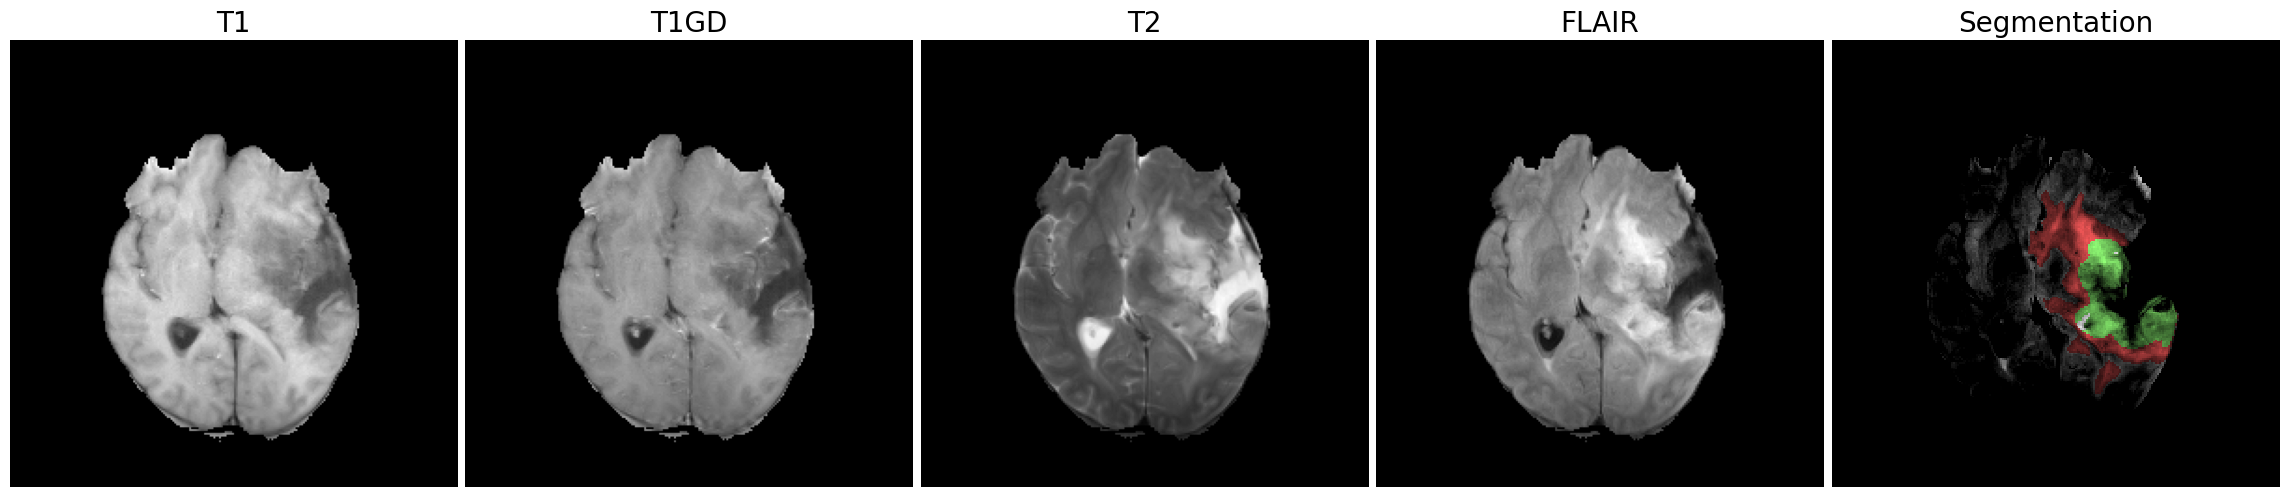

patient_id=Gliomas_00012_20190906
max_nonzero_count=1863, index=67


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


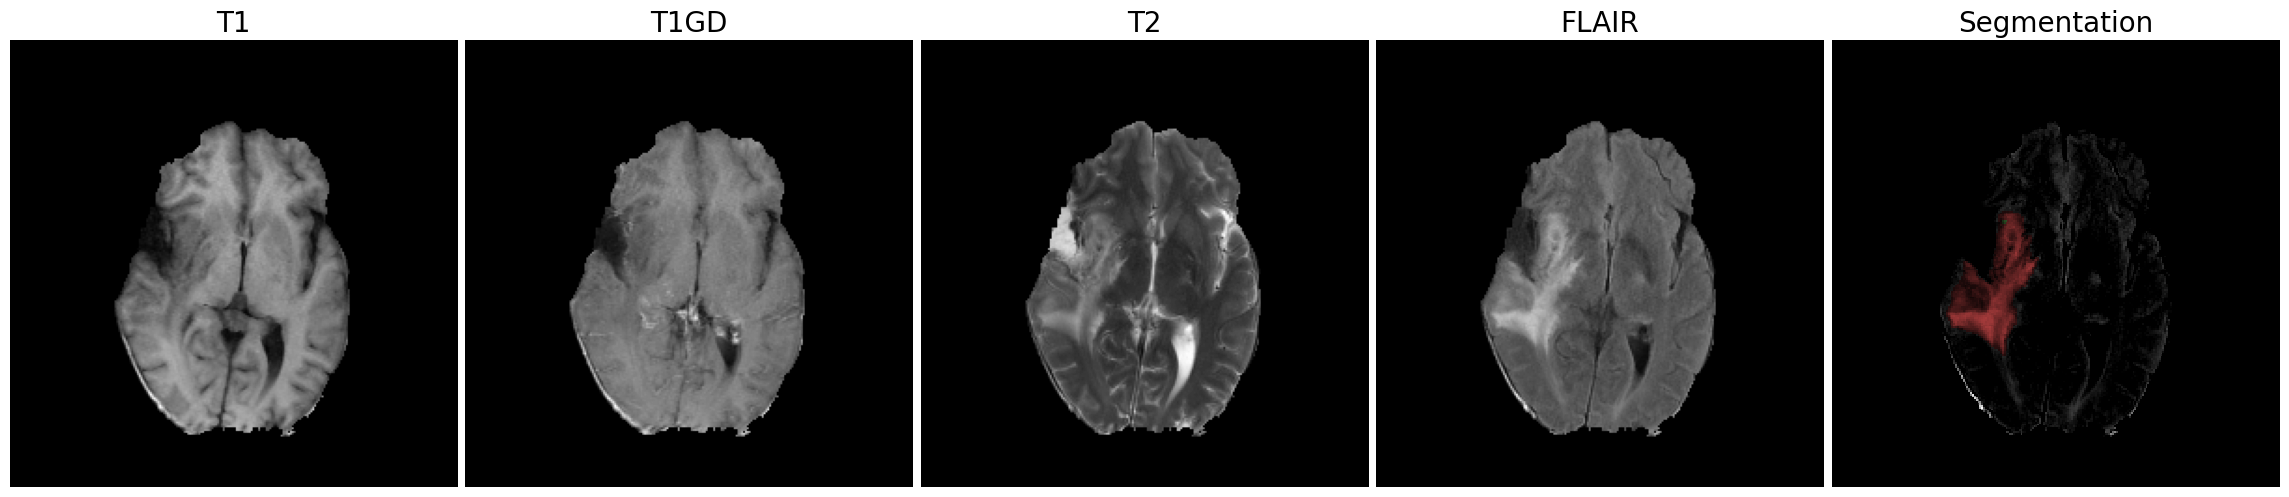

patient_id=Gliomas_00019_20181024
max_nonzero_count=435, index=76


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


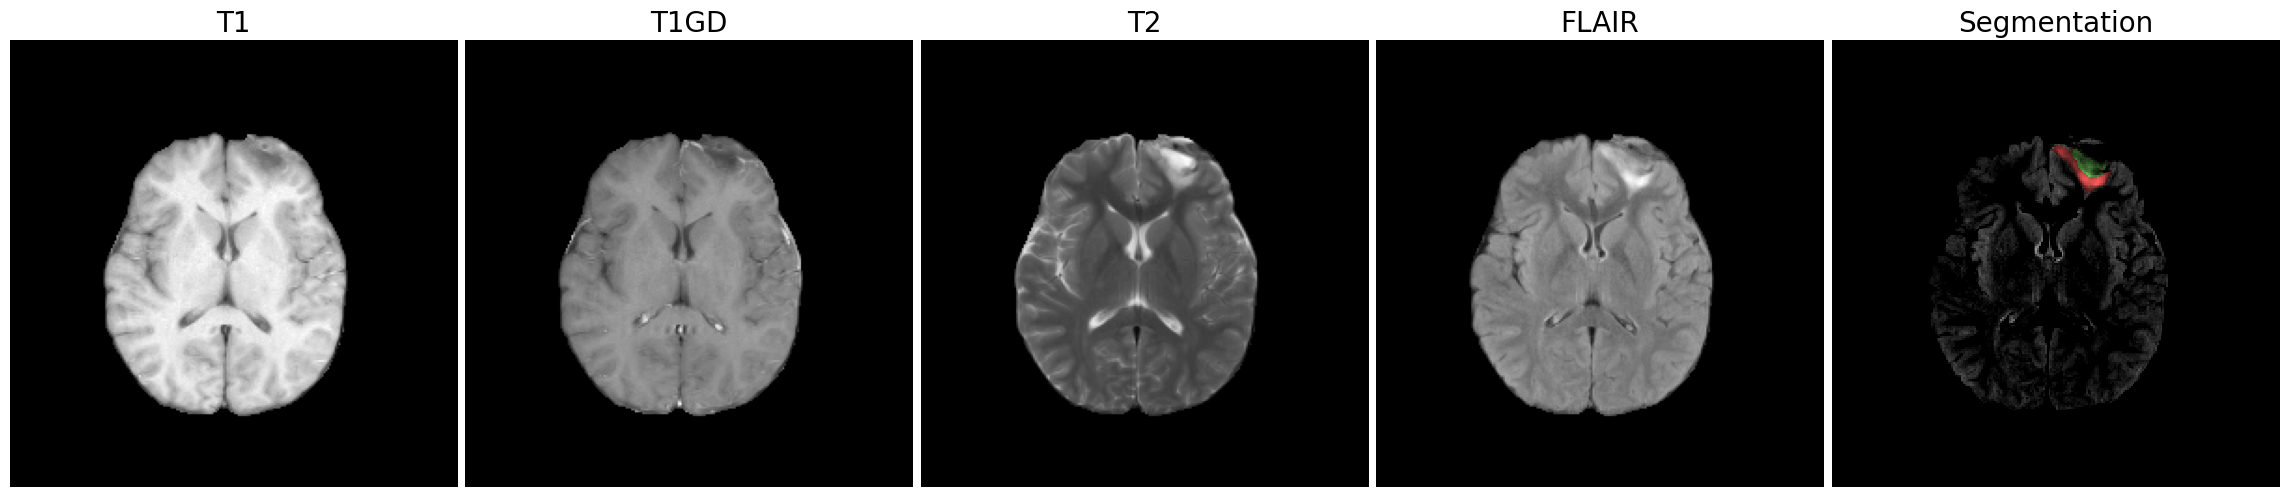

patient_id=Gliomas_00028_20191209
max_nonzero_count=4709, index=90


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


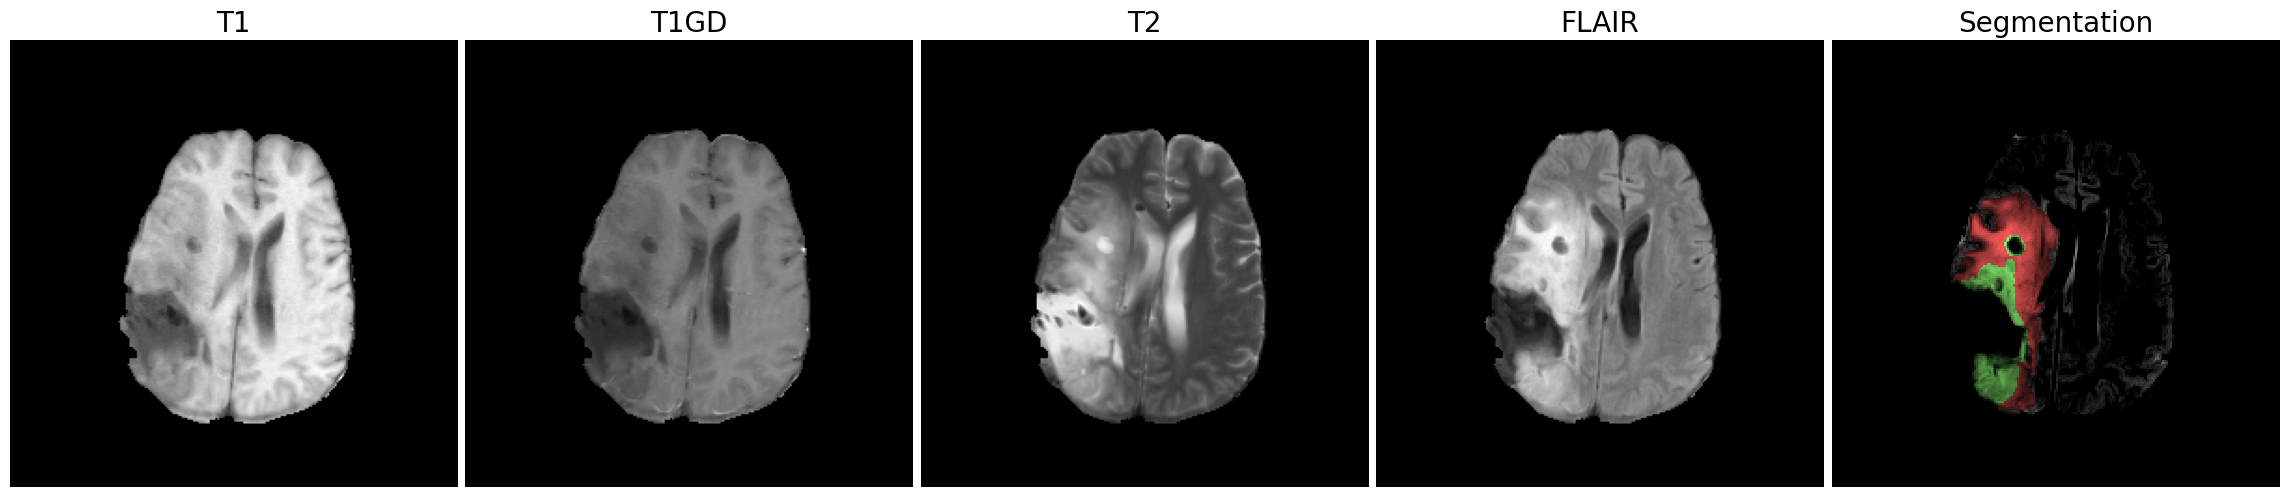

patient_id=Gliomas_00034_20190214
max_nonzero_count=2537, index=93


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


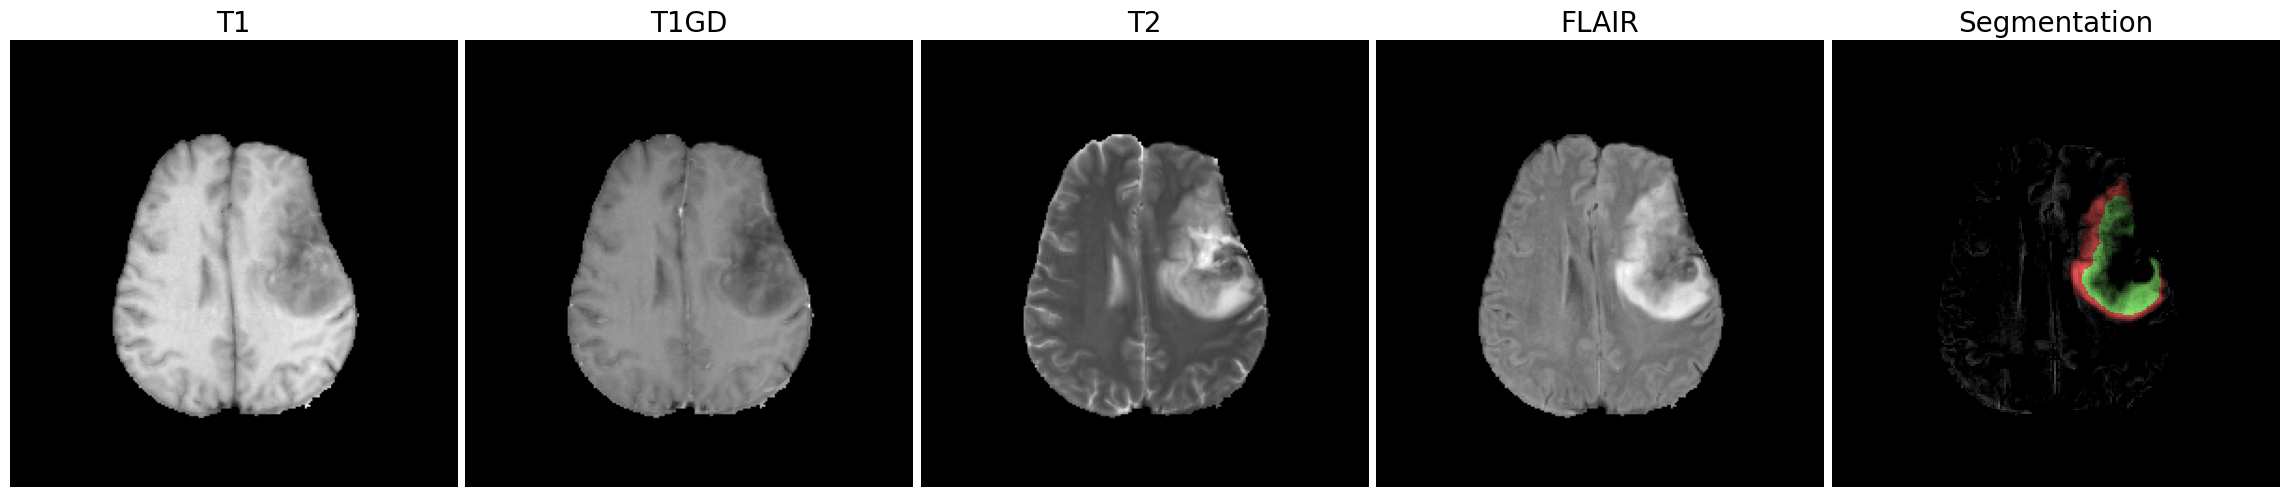

patient_id=Gliomas_00035_20170316
max_nonzero_count=2627, index=69


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


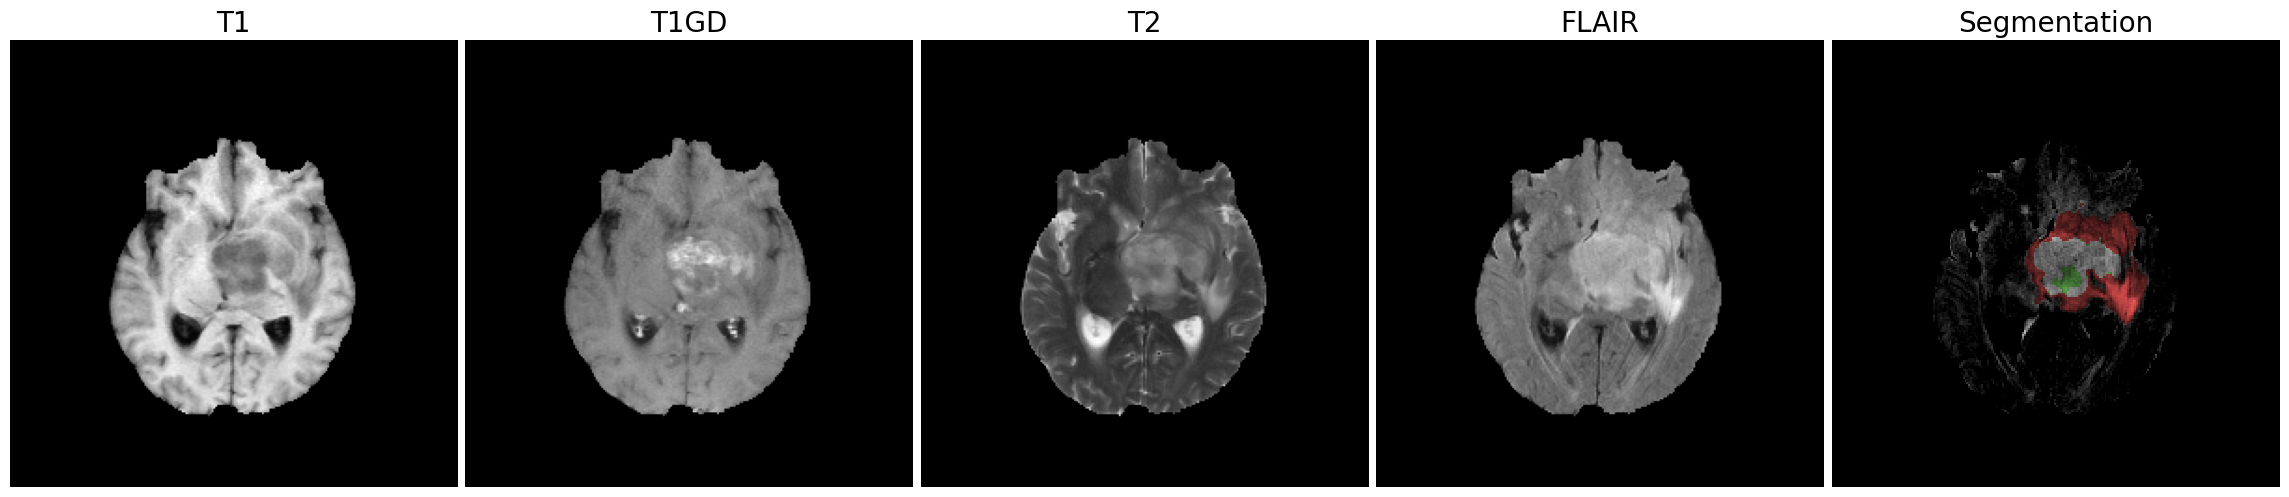

patient_id=Gliomas_00036_20141215
max_nonzero_count=2835, index=80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


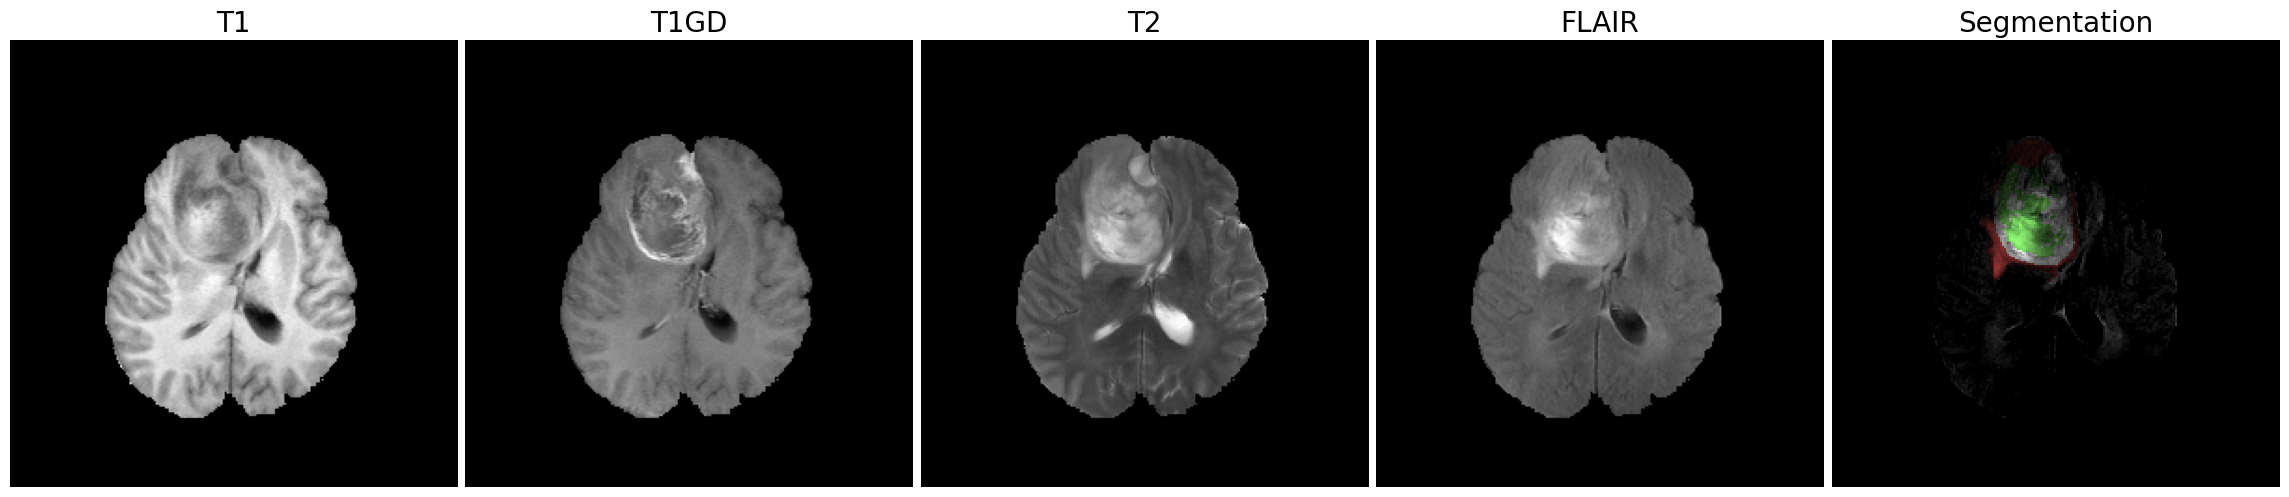

patient_id=Gliomas_00039_20180109
max_nonzero_count=3738, index=88


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


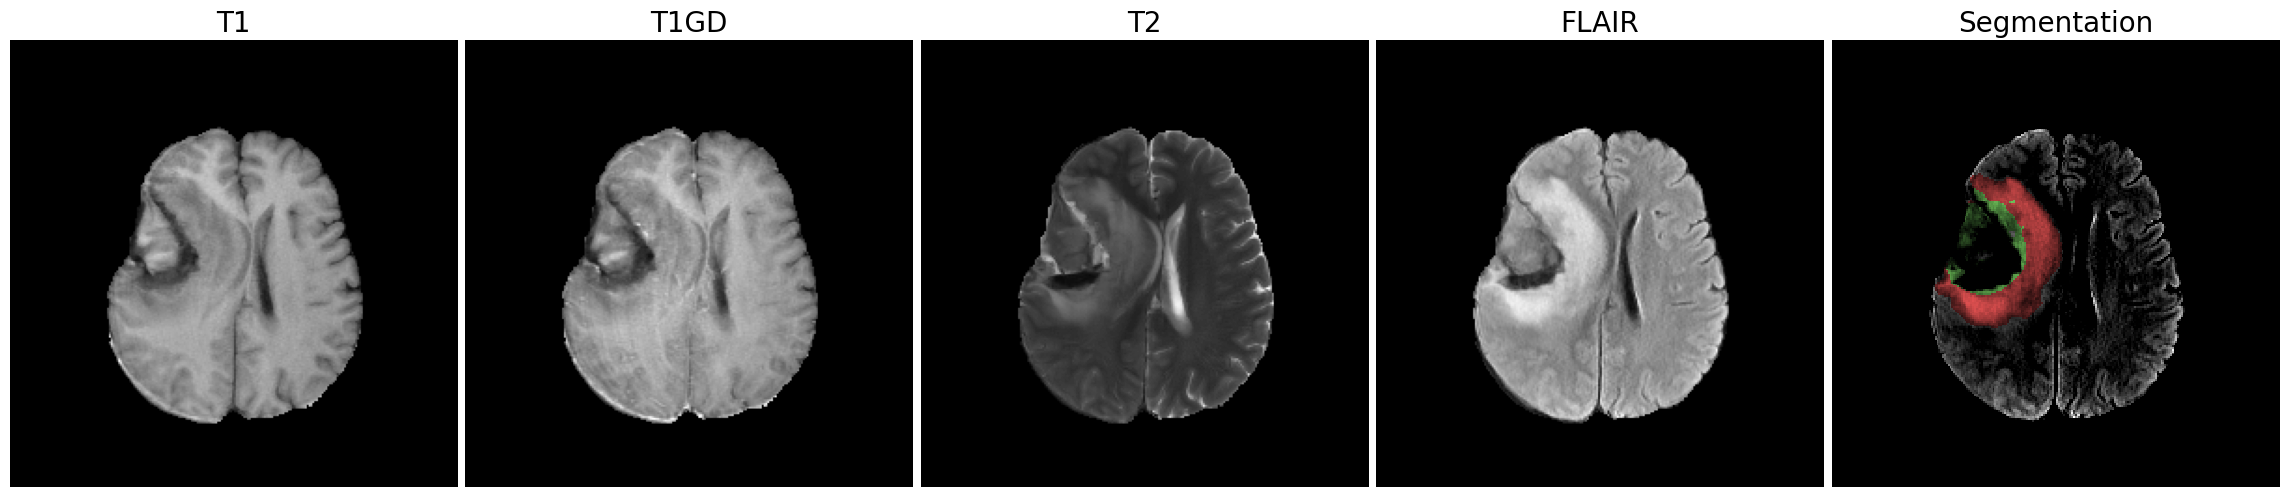

patient_id=Gliomas_00040_20190312
max_nonzero_count=3918, index=105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


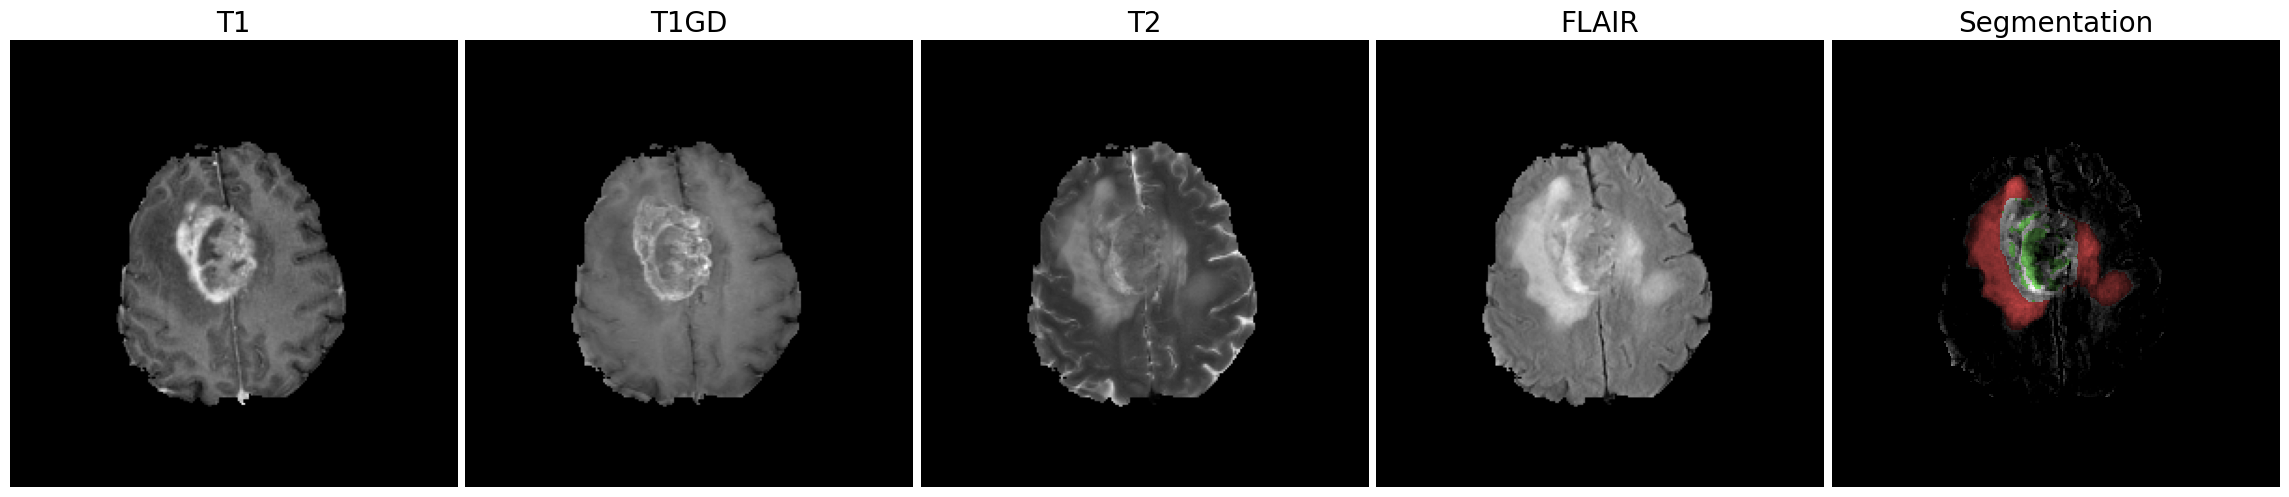

patient_id=Gliomas_00045_20190329
max_nonzero_count=2849, index=80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


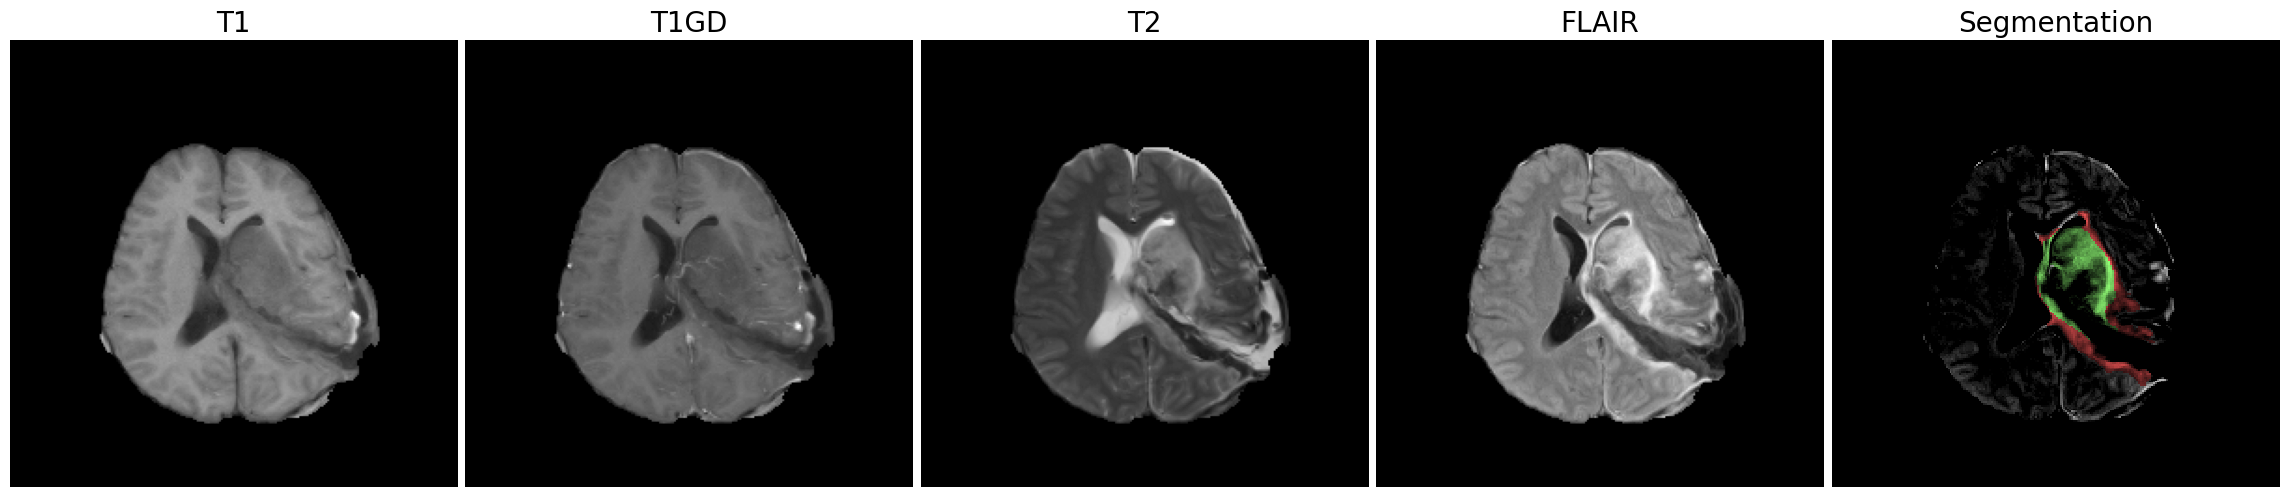

patient_id=Gliomas_00048_20180830
max_nonzero_count=0, index=0


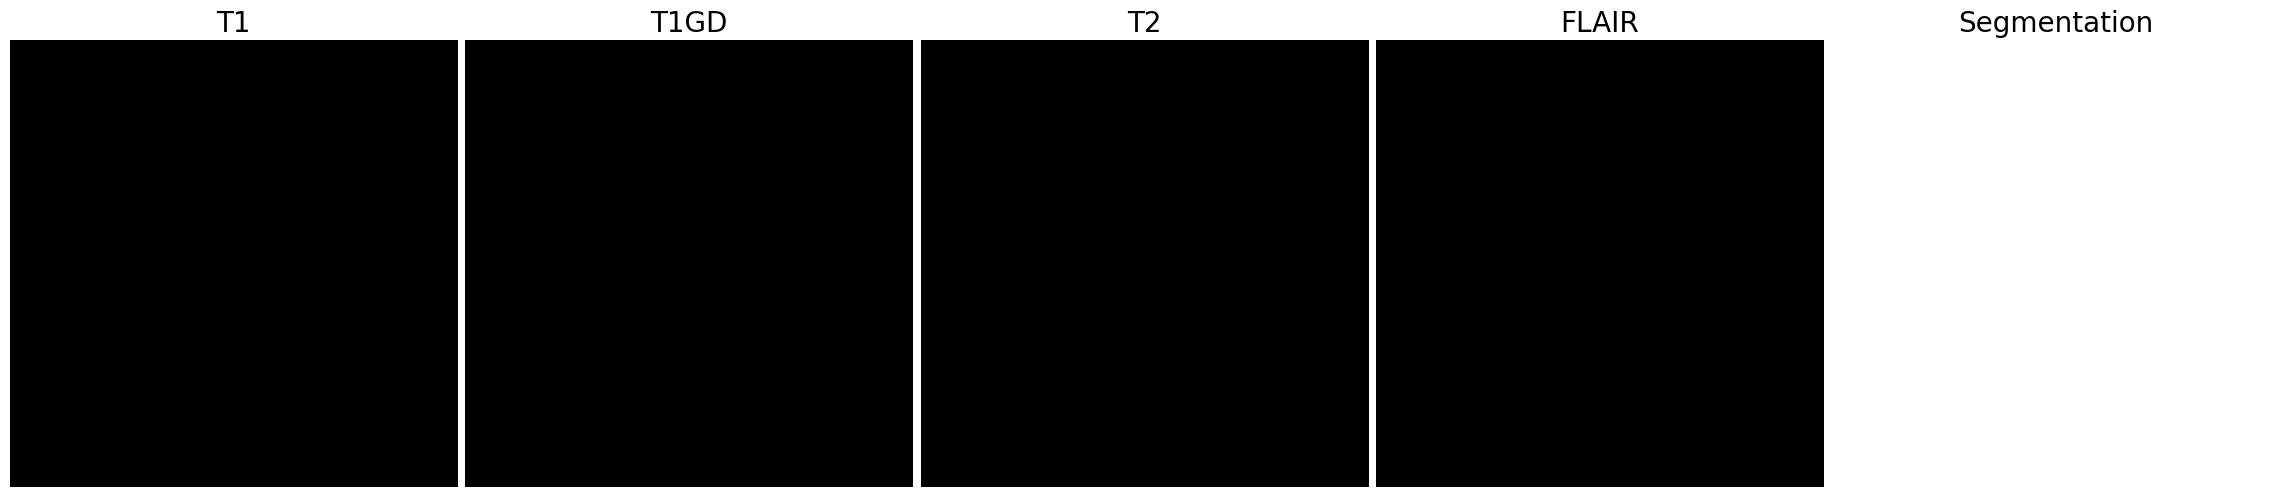

patient_id=Gliomas_00049_20161010
max_nonzero_count=4132, index=57


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


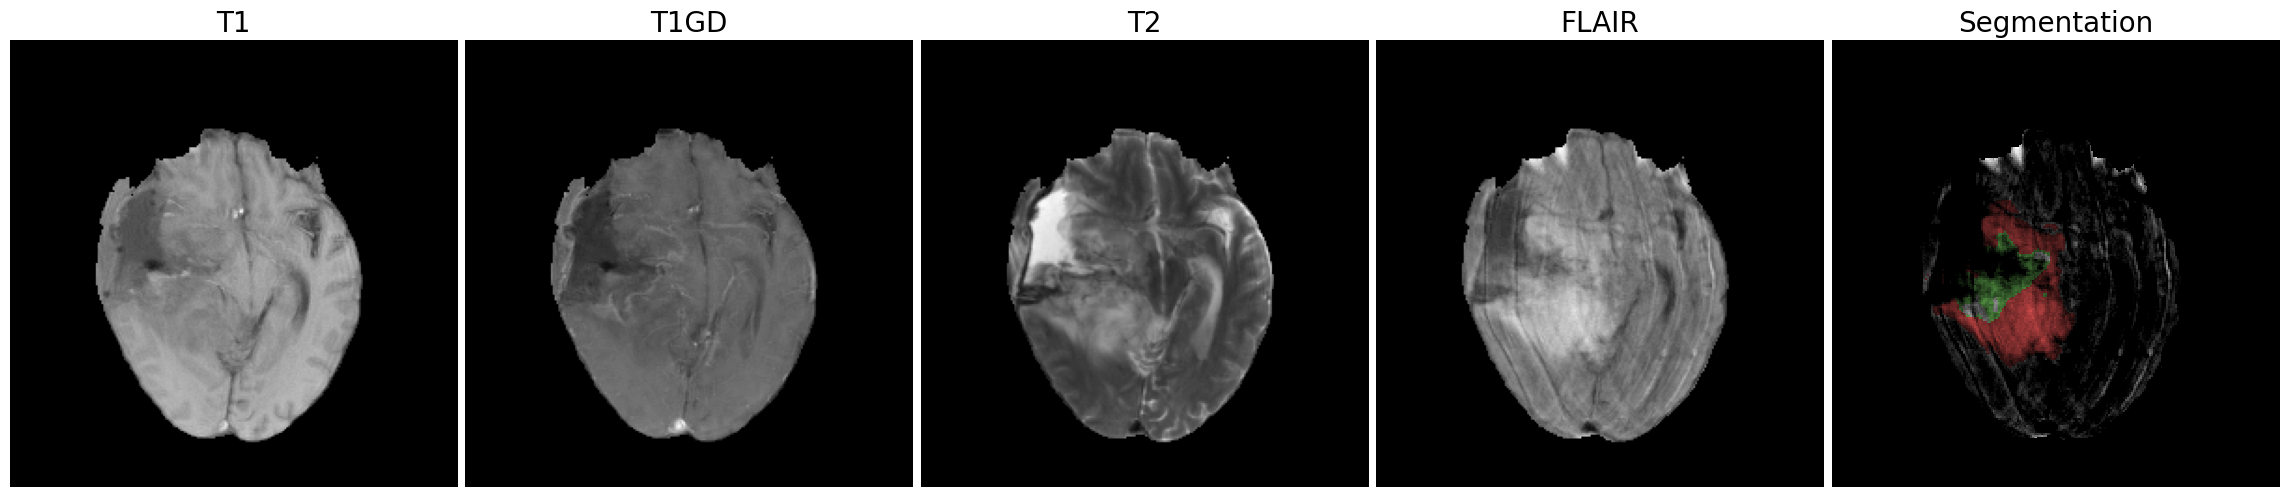

patient_id=Gliomas_00053_20181227
max_nonzero_count=3130, index=83


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
image_visualization_setting_dict=get_image_visualization_setting_dict()
for setting_name, image_visualization_setting in image_visualization_setting_dict.items():
    image_base_folder=image_visualization_setting["image_folder"]
    segmentation_folder=image_visualization_setting["segmentation_folder"]
    modality_list=image_visualization_setting["modality_list"]
    save_visualization_folder=image_visualization_setting["save_visualization_folder"]
    mkdir(save_visualization_folder)
    visualize_image_and_segmentations(image_base_folder, segmentation_folder, modality_list, save_visualization_folder)